<a href="https://colab.research.google.com/github/FreMeli/Teo_Riesgo/blob/main/MiniProyecto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#pip install pandas openpyxl xlrd

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from google.colab import files

In [3]:
uploaded = files.upload()

Saving MiniPoryecto 2.xlsm to MiniPoryecto 2 (2).xlsm


In [4]:
df = pd.read_excel('MiniPoryecto 2.xlsm', engine='openpyxl')

# Mostrar las primeras filas del DataFrame
print(df.head())

   No. Sinientros    Clave Numero de Siniestro     Fecha del Siniestro  \
0               1  POL0001             SIN0455 2023-07-26 21:21:58.648   
1               2  POL0001             SIN0505 2023-09-12 02:02:02.667   
2               3  POL0002             SIN0267 2023-03-13 07:34:49.624   
3               4  POL0004             SIN0003 2023-01-01 00:08:33.249   
4               5  POL0004             SIN0422 2023-06-28 11:19:24.372   

   Valor de los Servicios  
0                27364.69  
1                46430.61  
2                58503.89  
3                32903.39  
4                28837.37  


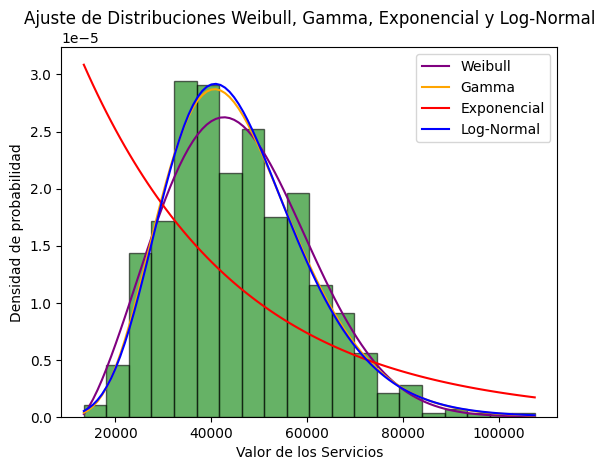

Prueba KS para Weibull: KstestResult(statistic=0.034521977026358786, pvalue=0.4544284800217846, statistic_location=41561.13, statistic_sign=1)
Prueba KS para Gamma: KstestResult(statistic=0.02908837662992364, pvalue=0.6721840329881795, statistic_location=37328.29, statistic_sign=1)
Prueba KS para Exponencial: KstestResult(statistic=0.2821872680780658, pvalue=2.975993565458589e-43, statistic_location=30910.81, statistic_sign=-1)
Prueba KS para Log-Normal: KstestResult(statistic=0.03154823487869174, pvalue=0.5705091715121822, statistic_location=37328.29, statistic_sign=1)


In [5]:
# Seleccionar la columna que contiene los datos de severidad (en este caso 'Valor de los Servicios')
severity_data = df['Valor de los Servicios']

# Ajuste a distribuciones Weibull, Gamma, Exponencial y Log-Normal
weibull_fit_params = stats.weibull_min.fit(severity_data)
gamma_fit_params = stats.gamma.fit(severity_data)
exp_fit_params = stats.expon.fit(severity_data)
lognorm_fit_params = stats.lognorm.fit(severity_data)

# Crear histograma de los datos
plt.hist(severity_data, bins=20, density=True, alpha=0.6, color='g', edgecolor='black')

# Generar valores para las curvas ajustadas
x = np.linspace(min(severity_data), max(severity_data), 100)

# Distribución Weibull
weibull_pdf = stats.weibull_min.pdf(x, *weibull_fit_params)
plt.plot(x, weibull_pdf, 'purple', label='Weibull')

# Distribución Gamma
gamma_pdf = stats.gamma.pdf(x, *gamma_fit_params)
plt.plot(x, gamma_pdf, 'orange', label='Gamma')

# Distribución Exponencial
exp_pdf = stats.expon.pdf(x, *exp_fit_params)
plt.plot(x, exp_pdf, 'red', label='Exponencial')

# Distribución Log-Normal
lognorm_pdf = stats.lognorm.pdf(x, *lognorm_fit_params)
plt.plot(x, lognorm_pdf, 'blue', label='Log-Normal')

# Añadir títulos y etiquetas
plt.title('Ajuste de Distribuciones Weibull, Gamma, Exponencial y Log-Normal')
plt.xlabel('Valor de los Servicios')
plt.ylabel('Densidad de probabilidad')
plt.legend()
plt.show()

# Realizar las pruebas de bondad de ajuste de Kolmogorov-Smirnov
ks_weibull_test = stats.kstest(severity_data, 'weibull_min', args=weibull_fit_params)
ks_gamma_test = stats.kstest(severity_data, 'gamma', args=gamma_fit_params)
ks_exp_test = stats.kstest(severity_data, 'expon', args=exp_fit_params)
ks_lognorm_test = stats.kstest(severity_data, 'lognorm', args=lognorm_fit_params)

# Mostrar los resultados de las pruebas KS
print("Prueba KS para Weibull:", ks_weibull_test)
print("Prueba KS para Gamma:", ks_gamma_test)
print("Prueba KS para Exponencial:", ks_exp_test)
print("Prueba KS para Log-Normal:", ks_lognorm_test)

#Calculando los parámetros

In [6]:
# Estimar los parámetros alpha y theta de la distribución Gamma
alpha, loc, theta = stats.gamma.fit(severity_data, floc=0)  # Ajuste forzando loc = 0 para simplificar

# Mostrar los valores estimados de alpha y theta
print(f"Valor estimado de alpha (forma): {alpha}")
print(f"Valor estimado de theta (escala): {theta}")

Valor estimado de alpha (forma): 9.906474660384172
Valor estimado de theta (escala): 4625.099489008762


##Contemlando solo deducible de 30,000

In [8]:
from scipy.special import gammainc, gamma
# Prima sin deducible (severidad promedio)
num_siniestros = 532
num_polizas = 500
frec=num_siniestros/num_polizas

Factor_Recargo=(df['Valor de los Servicios'].std()/(alpha * theta))*1.645
expected_loss_no_deductible = alpha * theta * (607/500)
print(f"Prima sin deducible: {expected_loss_no_deductible}")

# Función para calcular el momento limitado (prima ajustada con deducible)
def limited_moment_gamma(alpha, theta, deductible, k=1):
    # Cálculo de la fórmula para el momento limitado
    gamma_incomplete_alpha_k = gamma(alpha + k) * gammainc(alpha + k, deductible / theta)
    gamma_incomplete_alpha = gammainc(alpha, deductible / theta)

    # Momento limitado ajustado con deducible
    moment_limited = (theta**k) * (gamma_incomplete_alpha_k / gamma(alpha)) + (deductible**k) * (1 - (gamma_incomplete_alpha))
    return moment_limited

# Definir varios valores de deducible
deductibles = [30000]

# Calcular la prima ajustada para cada deducible
for deductible in deductibles:
    adjusted_premium = limited_moment_gamma(alpha, theta, deductible)*(1+Factor_Recargo) *frec
    print(f"Prima ajustada con deducible de {deductible}: {adjusted_premium}")

# Comparar con la prima sin deducible para ver el descuento en función del deducible
    discount = ((expected_loss_no_deductible - adjusted_premium) / expected_loss_no_deductible) * 100
    print(f"Descuento ofrecido para deducible de {deductible}: {discount:.2f}%\n")


Prima sin deducible: 55623.575099999995
Prima ajustada con deducible de 30000: 47639.181232550516
Descuento ofrecido para deducible de 30000: 14.35%



##Prima con límite de cobertura

In [11]:
num_siniestros = 594
num_polizas = 500
frec=num_siniestros/num_polizas

# Función para calcular el momento limitado de una distribución Gamma
def limited_moment_gamma(alpha, theta, deductible, limit, k=1):
    # Si no hay límite superior (limite es infinito), lo evaluamos como np.inf
    if limit == np.inf:
        gamma_incomplete_alpha_k_limit = 0  # No hay límite superior, por lo que esta parte es 0
        gamma_incomplete_alpha_limit = 0    # No hay límite superior, por lo que esta parte es 0
    else:
        # Cálculo para el límite superior (momento limitado en el límite)
        gamma_incomplete_alpha_k_limit = gamma(alpha + k) * gammainc(alpha + k, limit / theta)
        gamma_incomplete_alpha_limit = gammainc(alpha, limit / theta)

    # Cálculo para el deducible (momento limitado en el deducible)
    gamma_incomplete_alpha_k_deductible = gamma(alpha + k) * gammainc(alpha + k, deductible / theta)
    gamma_incomplete_alpha_deductible = gammainc(alpha, deductible / theta)

    # Momento limitado ajustado con deducible y límite
    moment_limited = (
        (theta ** k) * ((gamma_incomplete_alpha_k_limit - gamma_incomplete_alpha_k_deductible) / gamma(alpha)) +
        (deductible ** k) * (1 - gamma_incomplete_alpha_deductible) +
        (limit ** k) * (1-gamma_incomplete_alpha_limit)
    )
    return moment_limited

# Ejemplo con un límite de cobertura de 60,000 y sin deducible
deductible = 0      # Sin deducible
limit = 80000       # Límite de cobertura de 60,000

# Calcular el momento limitado de primer orden (k=1) para obtener la severidad esperada ajustada
moment_limited_value = limited_moment_gamma(alpha, theta, deductible, limit)*frec
print(f"Valor del momento limitado con límite de cobertura de {limit} y sin deducible: {moment_limited_value:.2f}")


Valor del momento limitado con límite de cobertura de 80000 y sin deducible: 54228.24


#Visualizando

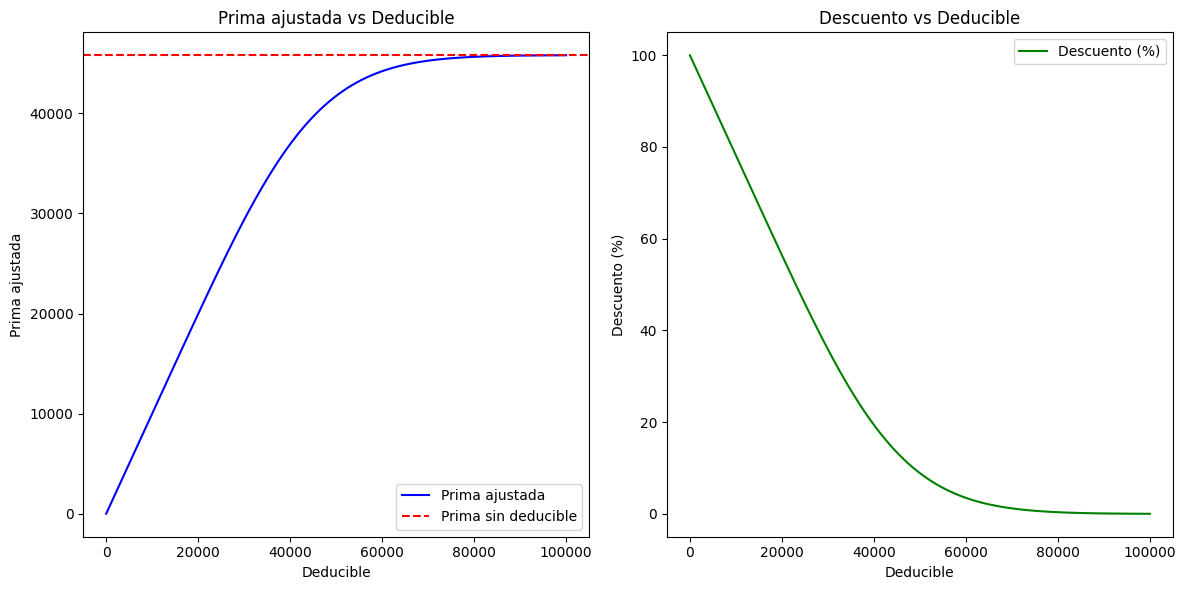

In [13]:
# Prima sin deducible (severidad promedio)
expected_loss_no_deductible = alpha * theta

# Función para calcular el momento limitado (prima ajustada con deducible)
def limited_moment_gamma(alpha, theta, deductible, k=1):
    # Cálculo de la fórmula para el momento limitado
    gamma_incomplete_alpha_k = gamma(alpha + k) * gammainc(alpha + k, deductible / theta)
    gamma_incomplete_alpha = gamma(alpha) * gammainc(alpha, deductible / theta)

    # Momento limitado ajustado con deducible
    moment_limited = (theta**k) * (gamma_incomplete_alpha_k / gamma(alpha)) + (deductible**k) * (1 - (gamma_incomplete_alpha / gamma(alpha)))
    return moment_limited

# Definir valores de deducible que queremos analizar
deductibles = np.linspace(0, 100000, 100)  # Valores de deducible entre 0 y 100,000

# Listas para almacenar los resultados
adjusted_premiums = []
discounts = []

# Calcular la prima ajustada para cada deducible y el descuento
for deductible in deductibles:
    adjusted_premium = limited_moment_gamma(alpha, theta, deductible)
    adjusted_premiums.append(adjusted_premium)

    # Calcular el descuento porcentual
    discount = ((expected_loss_no_deductible - adjusted_premium) / expected_loss_no_deductible) * 100
    discounts.append(discount)

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Gráfica del momento limitado (prima ajustada) vs. deducible
plt.subplot(1, 2, 1)
plt.plot(deductibles, adjusted_premiums, label="Prima ajustada", color='b')
plt.axhline(y=expected_loss_no_deductible, color='r', linestyle='--', label="Prima sin deducible")
plt.title('Prima ajustada vs Deducible')
plt.xlabel('Deducible')
plt.ylabel('Prima ajustada')
plt.legend()

# Gráfica del descuento vs. deducible
plt.subplot(1, 2, 2)
plt.plot(deductibles, discounts, label="Descuento (%)", color='g')
plt.title('Descuento vs Deducible')
plt.xlabel('Deducible')
plt.ylabel('Descuento (%)')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()
